In [74]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import random
from pathlib import Path
from dataloader import get_dataloader, walk_through_dir
from models import SegmentationModel

In [75]:
data_path = "/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/"
walk_through_dir(Path(data_path))

There are 2 directories and 2 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data'.
There are 7 directories and 0 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield'.
There are 0 directories and 2475 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well5_225locations'.
There are 0 directories and 2475 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well4_225locations'.
There are 0 directories and 1485 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well6_135locations'.
There are 0 directories and 2156 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well3_200locations'.
There are 0 directories and 1485 images in '/zhome/70/5/14854/nobackup/deeplearningf24/forcebiology/data/brightfield/Alexa488_Fibroblasts_well7_

In [76]:
image_dirs = [data_path + 'brightfield/Alexa488_Fibroblasts_well1_50locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well2_200locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well3_200locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well4_225locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well5_225locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well6_135locations',
              data_path + 'brightfield/Alexa488_Fibroblasts_well7_135locations']
mask_dir = data_path + 'masks'

In [77]:
def set_seed(seed=111):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU
    random.seed(seed)
    np.random.seed(seed)

In [78]:
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
mask_transform = data_transform

train_dataloader, val_dataloader, test_dataloader = get_dataloader(
    image_dirs, 
    mask_dir, 
    data_transform, 
    mask_transform, 
    display_sample=False, 
    train_percentage=1.0, 
    channel_indices=None
)

Number of images in the trainset: 889
Number of images in the valset: 223
Number of images in the testset: 50


In [79]:
def run_model(channels, pth_model, model_name):
    # Get the dataloaders with optional channel selection
    train_dataloader, val_dataloader, test_dataloader = get_dataloader(
        image_dirs, 
        mask_dir, 
        data_transform, 
        mask_transform, 
        display_sample=False, 
        train_percentage=1.0, 
        channel_indices=channels
    )

    # Initialize the device
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = "cpu"
    criterion = nn.BCELoss()
    current_directory = os.getcwd()
    model_save_path = os.path.join(current_directory, pth_model)

    # Load the model
    if model_name == "Simple":
        model = SimpleSegmentationModel().to(device)
    elif model_name == "UNet":
        model = SegmentationModel(channels=len(channels)).to(device)
    elif model_name == "Pretrained":
        model = pretrained_UNet().to(device)
    
    model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu'), weights_only=True))
    print(f"Model {pth_model} loaded successfully.")

    return model, test_dataloader, criterion, device

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

set_seed()

Using device: cuda


## Evaluation

In [98]:
current_directory = os.getcwd()
model_save_path = os.path.join(current_directory, "models/segmentation_model_UNet_train100%_channels0_1_2_3_4_5_6_7_8_9_10.pth")
criterion = nn.BCELoss()

model, test_dataloader, criterion, device = run_model([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], model_save_path, "UNet")

Number of images in the trainset: 889
Number of images in the valset: 223
Number of images in the testset: 50
Model /zhome/44/2/213836/02456/multiview-seg-dtu/models/segmentation_model_UNet_train100%_channels0_1_2_3_4_5_6_7_8_9_10.pth loaded successfully.


torch.Size([1, 128, 128])


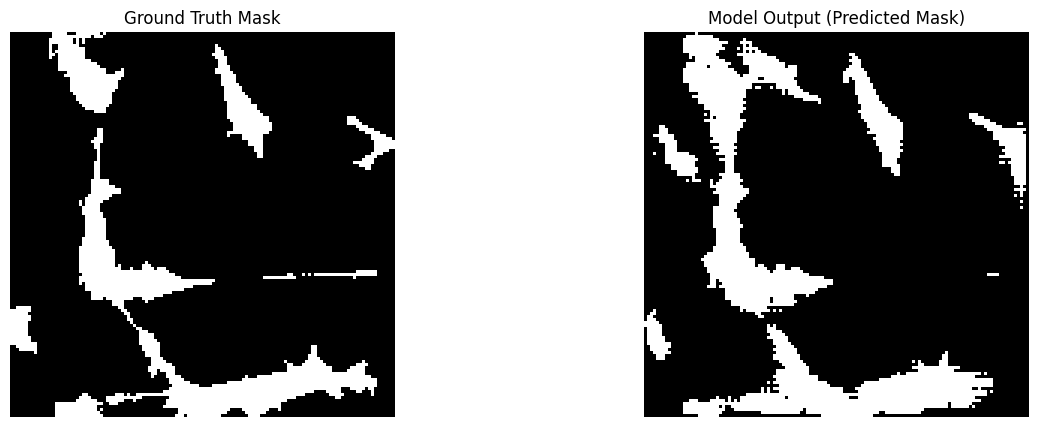

In [105]:
# Sample evaluation
batch = next(iter(test_dataloader))  # Get one batch
images, masks = batch
random_idx = random.randint(0, images.size(0) - 1)  # Random index within batch size
random_images = images.to(device)
random_mask = masks[random_idx].to(device) # Select only one random sample to plot

model.eval()

with torch.no_grad():  # No gradient computation needed for inference
    output = model(random_images)[random_idx]  # Forward pass and select only random sample to plot

print(output.shape)
binary_output = (output > torch.quantile(output, 0.8)).float() # Make binary segmentation

# Plot the input image, ground truth mask, and predicted mask
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(random_mask.cpu().squeeze().numpy(), cmap="gray")
axes[0].axis("off")
axes[0].set_title("Ground Truth Mask")

axes[1].imshow(binary_output.cpu().squeeze().numpy(), cmap="gray") # Change to binary_output if want to display binary mask
axes[1].axis("off")
axes[1].set_title("Model Output (Predicted Mask)")

plt.show()